In [81]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path

In [82]:
def unique(myList): return sorted(list(set(myList)))
def get_df_from_path(hdf5filePath):
    h = h5py.File(hdf5filePath, 'r+')
    history = h['history']
    colnames = history.attrs['column_names']
    assert len(history) == len(colnames)
    nbcols = len(colnames)
    _ = dict()
    for i, colname in zip(range(nbcols), colnames):
        _[colname] = history[i]
    return pd.DataFrame(_)

def get_info_from_path(hdf5filePath):
    #'HDF5Files/toyRates_logM-0.1_X0.6.hdf5' is a filepath, get logM and X from it
    logM = float(hdf5filePath.split('logM')[1].split('_')[0])
    X = float(hdf5filePath.split('X')[1].split('_')[0])
    return logM, X

def get_µ_from_X(X): return 4 / ( 3 + 5*X )
def get_X_from_µ(µ): return ( 4 - 3*µ ) / ( 5*µ )
#benadering: M(H1) is niet helemaal 1, en dan nog isotopenbenadering en Z = A/2 ofzo enzo

class Track:    
    def __init__(self, hdf5filePath, H_cutoff = 0.999, Temp_reference = 10**3.0):
        self.path = hdf5filePath
        self.history = get_df_from_path(hdf5filePath)
        self.logM, self.X = get_info_from_path(hdf5filePath)
        self.M = 10**self.logM
        self.Mround = round(self.M, 1)
        self.µ = get_µ_from_X(self.X)
        self.ZAMS_L = None
        self.PMS_L = None
        self.ZAMS_index = self.compute_ZAMS_index(H_cutoff)
        self.PMS_index = self.compute_PMS_index(Temp_reference)

    def compute_ZAMS_index(self, H_cutoff=0.999):
        try:
            index = np.where(self.history.X_center < H_cutoff * self.history.X_center[0])[0][0]
        except:
            return None
        self.ZAMS_index = index
        self.ZAMS_index_calculated = True
        self.ZAMS_L = self.history.L_surf[self.ZAMS_index]
        return index

    def compute_PMS_index(self, Temp_reference = 10**3.0):
        if self.ZAMS_index == None:
            return None
        index = np.argmin(self.history.T_surf[0:self.ZAMS_index] - Temp_reference)
        self.PMS_index = index
        self.PMS_L = self.history.L_surf[self.PMS_index]
        return index
    
    def compute_indices(self, H_cutoff=0.999, Temp_reference = 10**3.0):
        self.compute_ZAMS_index(H_cutoff)
        self.compute_PMS_index(Temp_reference)
    
    def get_gridpoint(self):
        return (self.logM, self.X)
    
    def plot_HRD_PMS(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_title('HRD')
        ax.set_xlabel('log(Teff)')
        ax.set_ylabel('log(L)')
        ax.plot(np.log10(self.history.T_surf), np.log10(self.history.L_surf), label=self.path)
        ax.inverse_xaxis()
        return ax

class Grid:
    def __init__(self, tracks):
        self.tracks = tracks
        self.gridpoints = [track.get_gridpoint() for track in tracks]
        print('Grid with', len(self.tracks), 'tracks')
        self.logMs = np.array([track.logM for track in tracks])
        self.Ms = np.array([track.M for track in tracks])
        self.Xs = np.array([track.X for track in tracks])
        self.µs = np.array([track.µ for track in tracks])
        self.ZAMS_Ls = np.array([track.ZAMS_L for track in tracks])
        self.PMS_Ls = np.array([track.PMS_L for track in tracks])
        self.failed_tracks = [track for track in tracks if track.ZAMS_index == None]
        #nb of logMs:
        self.nb_logMs = len(set(self.logMs))
    def get_info(self):
        print('Grid with', len(self.tracks), 'tracks')
        print('logMs:', self.logMs)
        print('Xs:', self.Xs)
        print('µs:', self.µs)
    def generate_cut_grid(self, logM_lo, logM_hi, X_lo, X_hi):
        return Grid([track for track in self.tracks if logM_lo <= track.logM <= logM_hi and X_lo <= track.X <= X_hi])
    def generate_cut_grid_µ(self, µ_lo, µ_hi):
        return Grid([track for track in self.tracks if µ_lo <= track.µ <= µ_hi])
    def collapse_grid_logM(self, logM):
        return Grid([track for track in self.tracks if track.logM == logM])
    def collapse_grid_X(self, X):
        return Grid([track for track in self.tracks if track.X == X])
    
    def colors_and_shapes(self):
        colors = plt.cm.viridis(np.linspace(0, 1, self.nb_logMs))
        colors = {np.round(logM,1):color for logM, color in zip(unique(self.logMs), colors)}
        shapes = ['o','s','*','X','D']
        shapes = {np.round(logM,1) : shapes[i%len(shapes)] for i, logM in enumerate(sorted(list(set(self.logMs))))}
        return colors, shapes
    def HRD_things(self, ax = None):
        colors, shapes = self.colors_and_shapes()
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_title('HR Diagram')
        ax.set_xlabel('$ \log(T_{eff} / K) $')
        ax.set_ylabel('$ \log(L / L_{\odot}) $')
        ax.invert_xaxis()
        return ax, colors, shapes
    
    def plot_HRD(self, ax = None):
        ax, colors, shapes = self.HRD_things(ax)
        for track in self.tracks:
            ax.plot(np.log10(track.history.T_surf), np.log10(track.history.L_surf), label=track.get_gridpoint())
            if track.ZAMS_index != None:
                ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]))
        return ax

    def plot_HRD_PMS(self, ax=None):
        ax, colors, shapes = self.HRD_things(ax)   
        if ax == None: fig, ax = plt.subplots()
        for index, track in enumerate(self.tracks):
            if track.ZAMS_index == None:
                continue
            ax.plot(np.log10(track.history.T_surf[0:track.ZAMS_index]), np.log10(track.history.L_surf[0:track.ZAMS_index]), color = colors[track.logM])
            #scatter zams
            ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]), color = colors[track.logM], marker = shapes[track.logM])
        return ax
    
    def plot_grid(self, ax = None ):
        colors, shapes = self.colors_and_shapes() 
        if ax == None: fig, ax = plt.subplots()
        ax.set_title('Grid')
        ax.set_xlabel('Mass $\log(M/M_{\odot})$')
        ax.set_ylabel('Hydrogen fraction X')
        for track in self.tracks:
            marker = 'x' if track.ZAMS_index == None else 'o'       
            ax.scatter(track.logM, track.X, color = colors[track.logM], marker = marker)
        secax = ax.secondary_yaxis('right', functions=(get_µ_from_X, get_X_from_µ))
        secax.set_ylabel('Mean molecular weight $\mu$', rotation=270, labelpad=15)

In [83]:
p = Path('.')
_ = list(p.glob('Histories_withoutPrad/*.hdf5'))
paths = [str(hdf5file) for hdf5file in _]
tracks = [Track(path) for path in paths]
totalGrid = Grid(tracks)

Grid with 142 tracks


/tmp/ipykernel_3142/1329268719.py:20: RuntimeWarning: divide by zero encountered in divide
  def get_X_from_µ(µ): return ( 4 - 3*µ ) / ( 5*µ )


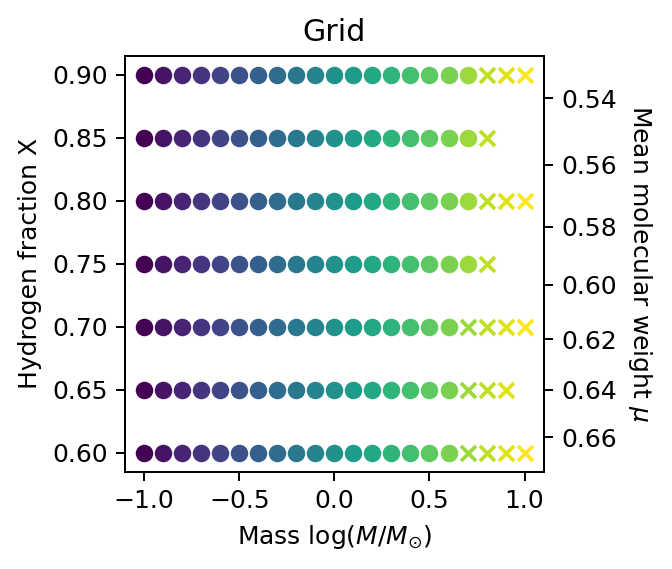

In [84]:
fig, ax = plt.subplots(1,1, figsize=(3,3),dpi=180)
totalGrid.plot_grid(ax)

In [85]:
#make a good grid
goodGrid = Grid([track for track in tracks if track.ZAMS_index != None])
badGrid = Grid([track for track in tracks if track.ZAMS_index == None])

Grid with 123 tracks
Grid with 19 tracks


<Axes: title={'center': 'HR Diagram'}, xlabel='$ \\log(T_{eff} / K) $', ylabel='$ \\log(L / L_{\\odot}) $'>

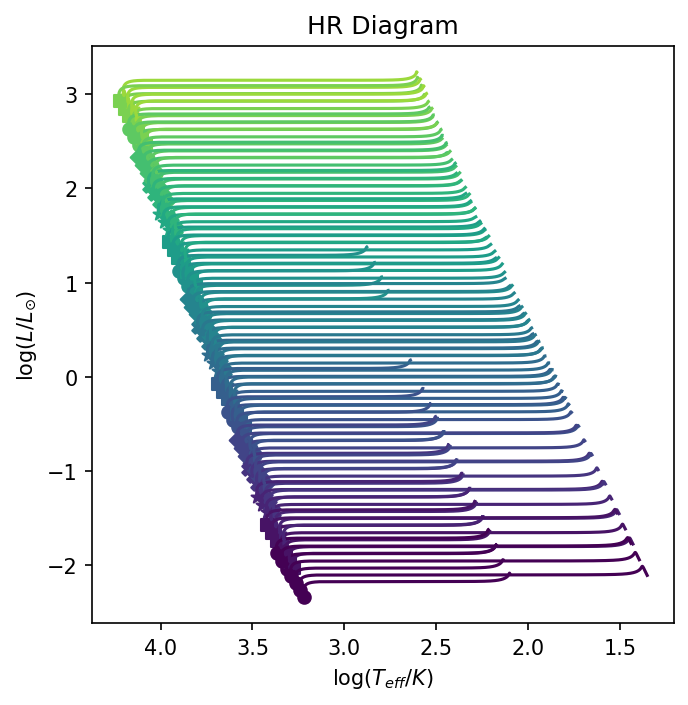

In [86]:
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=150)
totalGrid.plot_HRD_PMS(ax)

Grid with 21 tracks


<Axes: title={'center': 'HR Diagram'}, xlabel='$ \\log(T_{eff} / K) $', ylabel='$ \\log(L / L_{\\odot}) $'>

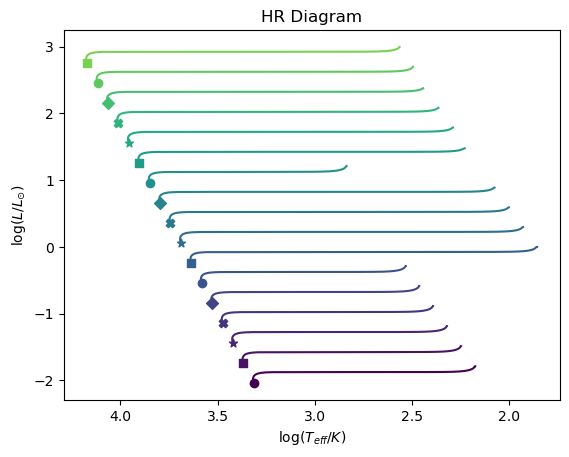

In [96]:
totalGrid.collapse_grid_X(0.7).plot_HRD_PMS()

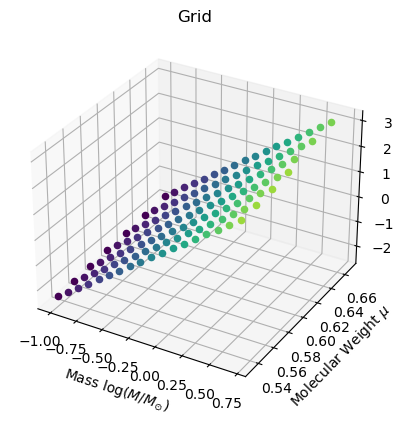

In [88]:
#%matplotlib widget 
#make a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Mass $\log(M/M_{\odot})$')
ax.set_ylabel('Molecular Weight $\mu$')
ax.set_zlabel('Luminosity at ZAMS $\log(L/L_{\odot})$')
ax.set_title('Grid')
for track in totalGrid.tracks:
    colors, shapes = totalGrid.colors_and_shapes()
    if track.ZAMS_L == None: continue
    ax.scatter(track.logM, track.µ, np.log10(track.ZAMS_L), color = colors[track.logM], marker = 'o')


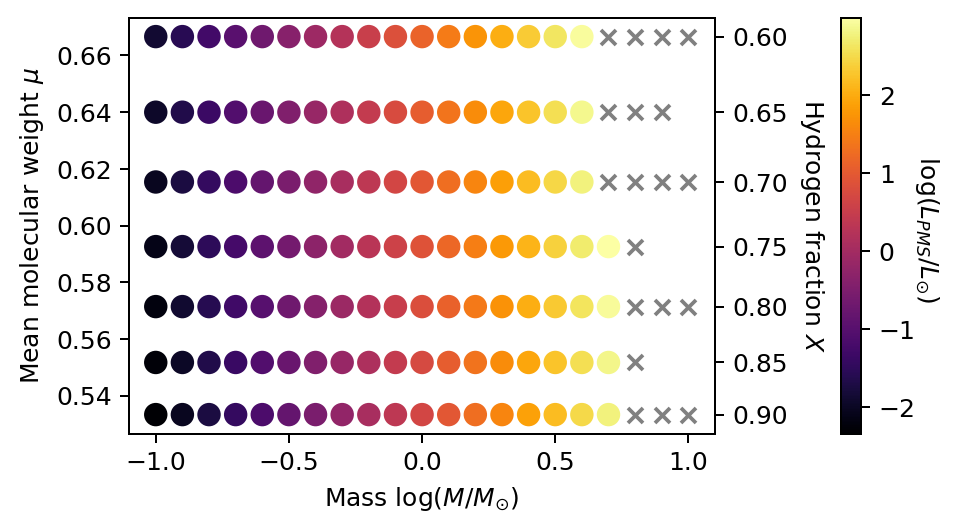

In [97]:
# Create a wider figure
fig = plt.figure(figsize=(6, 3),dpi=180)

# Add a subplot to this figure, leaving space on the right
ax = fig.add_subplot(111)

ax.scatter(badGrid.logMs, badGrid.µs, color = 'gray', marker = 'x')
#make colors based on totalGrid.ZAMS_Ls
colors =  np.log10(goodGrid.ZAMS_Ls)
plotting = ax.scatter(goodGrid.logMs, goodGrid.µs, c = colors, cmap = 'inferno',s=70)


# Add a colorbar to the figure
cbar = fig.colorbar(plotting, ax=ax, pad=0.15)
cbar.set_label(' $\log(L_{PMS}/L_{\odot})$',rotation=270,labelpad=10)

ax.set_xlabel('Mass $\log(M / M_{\odot})$')
ax.set_ylabel('Mean molecular weight $\mu$')

secax = ax.secondary_yaxis('right', functions=(get_X_from_µ,get_µ_from_X))
secax.set_ylabel('Hydrogen fraction $X$', rotation=270, labelpad=15)
ax.set_xticks(np.arange(-1,1.1,0.5))

## Some Analysis


In [ ]:
import lmfit
from scipy import stats

## One single fit

In [ ]:
def L_model(X, M, c1, c2,c3):
    f = (3+5*X)**4*(1+X)
    return c1 * f**c2  * M**c3

def logL_model(X, M, A, c2,c3):
    f = (3+5*X)**4*(1+X)
    return A + c2 * np.log10(f) + c3 * np.log10(M)

model1 = lmfit.Model(L_model, independent_vars = ['X', 'M'])
model1.set_param_hint('c1', value=1, min=0)
model1.set_param_hint('c2', value=-1, min=-10, max=10)
model1.set_param_hint('c3', value=3, min=-5, max = 10)
fit1 = model1.fit(goodGrid.PMS_Ls, X = goodGrid.Xs, M = goodGrid.Ms)
print(fit1.fit_report())

[[Model]]
    Model(L_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 204
    # data points      = 120
    # variables        = 3
    chi-square         = 1511.43418
    reduced chi-square = 12.9182409
    Akaike info crit   = 309.998703
    Bayesian info crit = 318.361178
    R-squared          = 0.99984385
[[Variables]]
    c1:  56406.7553 +/- 1354.70583 (2.40%) (init = 1)
    c2: -1.03433839 +/- 0.00334151 (0.32%) (init = -1)
    c3:  3.09308748 +/- 0.00646654 (0.21%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2) = -0.9437
    C(c2, c3) = -0.4799
    C(c1, c3) = +0.1651


In [ ]:
sigma = stats.norm.ppf(0.995)
print(fit1.ci_report(sigmas = [1,2,sigma], with_offset=False))

       99.00%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.00%
 c1:52971.3825653735.5166755063.4401456406.7553557783.0250459211.5728660066.27381
 c2:  -1.04310  -1.04110  -1.03770  -1.03434  -1.03098  -1.02758  -1.02559
 c3:   3.07611   3.07997   3.08656   3.09309   3.09963   3.10626   3.11017


In [ ]:
model2 = lmfit.Model(logL_model, independent_vars = ['X', 'M'])
model2.set_param_hint('A', value=1, min=0)
model2.set_param_hint('c2', value=-1, min=-10, max=10)
model2.set_param_hint('c3', value=3, min=-5, max = 10)
fit2 = model2.fit(np.log10(goodGrid.PMS_Ls), X = goodGrid.Xs, M = goodGrid.Ms)
print(fit2.fit_report())

[[Model]]
    Model(logL_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 120
    # variables        = 3
    chi-square         = 0.03004601
    reduced chi-square = 2.5680e-04
    Akaike info crit   = -989.102040
    Bayesian info crit = -980.739565
    R-squared          = 0.99988757
[[Variables]]
    A:   4.67644459 +/- 0.03376763 (0.72%) (init = 1)
    c2: -0.99969660 +/- 0.00948307 (0.95%) (init = -1)
    c3:  2.99701660 +/- 0.00294927 (0.10%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, c2) = -0.9989


Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 18 tracks
Grid with 16 tracks
Grid with 18 tracks


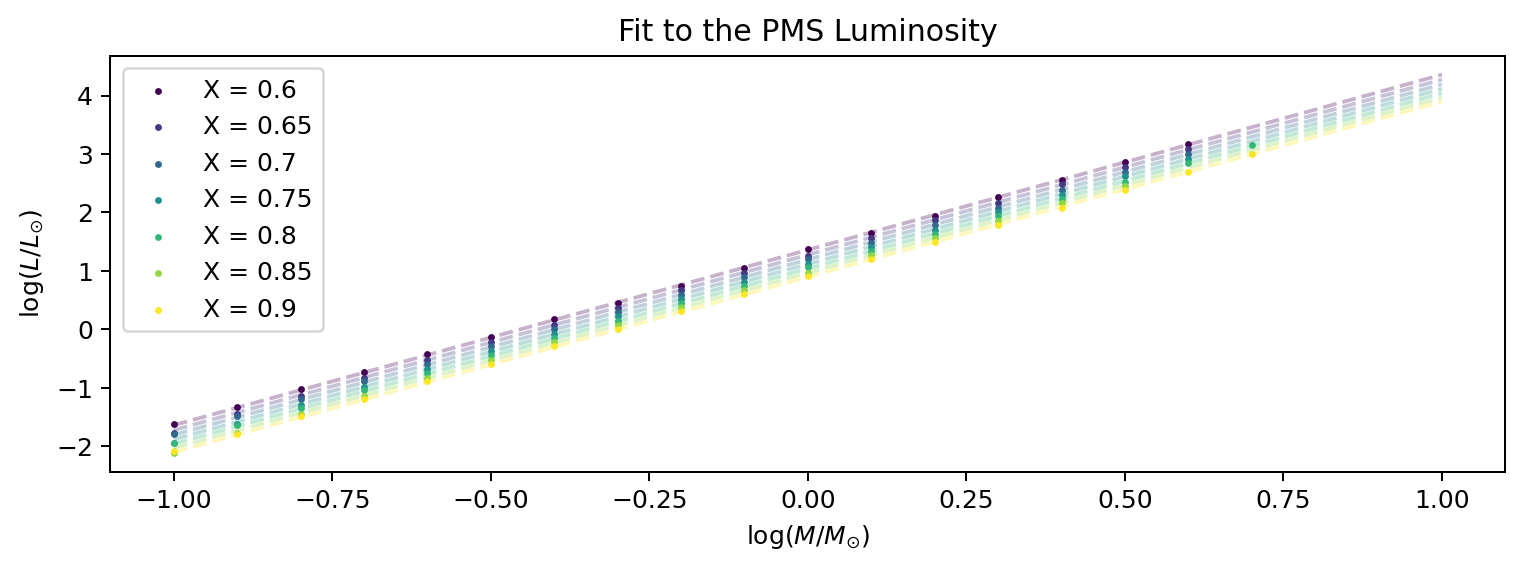

In [ ]:
#make plot of the fit
fig, ax = plt.subplots(1,1, figsize=(10,3),dpi=180)
ax.set_title('Fit to the PMS Luminosity')
ax.set_xlabel('$\log(M/M_{\odot})$')
ax.set_ylabel('$\log(L/L_{\odot})$')

logMrange = np.linspace(-1,1,100)
Xs = sorted(list(set(goodGrid.Xs)))
#Xs = [0.6,0.7,0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(Xs)))
for X, color in zip(Xs,colors):
    cutGrid = goodGrid.collapse_grid_X(X)
    ax.scatter(cutGrid.logMs, np.log10(cutGrid.PMS_Ls), label = f'X = {X}', marker = 'o',color=color,s=3)
    ax.plot(logMrange, fit2.eval(X = X, M = 10**logMrange),alpha = 0.3, ls='--',color=color)
    #uncertainties = fit2.eval_uncertainty(X = X, M = 10**logMrange, sigma=5)
    #ax.fill_between(logMrange, fit2.eval(X = X, M = 10**logMrange) - uncertainties, fit2.eval(X = X, M = 10**logMrange) + uncertainties, alpha = 1, color = 'tab:blue')
ax.legend()

Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 18 tracks
Grid with 16 tracks
Grid with 18 tracks


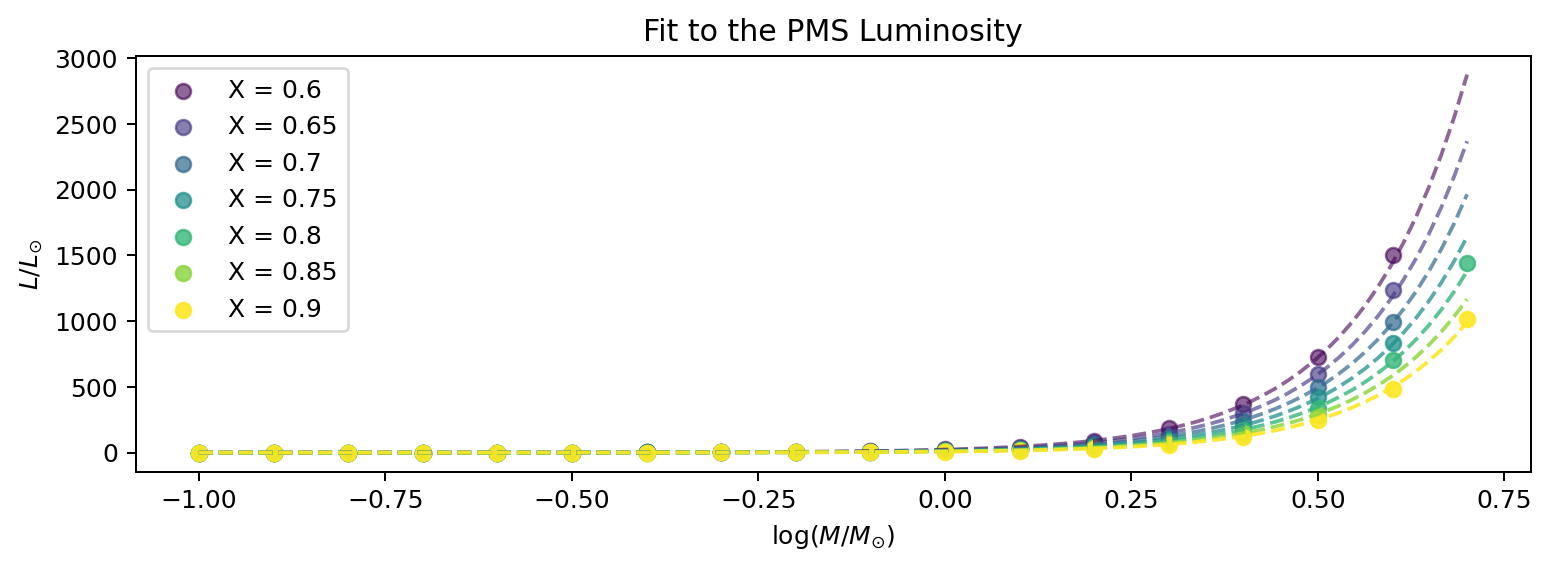

In [ ]:
#make plot of the fit
fig, ax = plt.subplots(1,1, figsize=(10,3),dpi=180)
ax.set_title('Fit to the PMS Luminosity')
ax.set_xlabel('$\log(M/M_{\odot})$')
ax.set_ylabel('$L / L_{\odot}$')

logMrange = np.linspace(-1,0.7,100)


Xs = sorted(list(set(goodGrid.Xs)))
#Xs = [0.6,0.7,0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(Xs)))
for X, color in zip(Xs,colors):
    cutGrid = goodGrid.collapse_grid_X(X)
    ax.scatter(cutGrid.logMs, cutGrid.PMS_Ls, label = f'X = {X}', marker = 'o',alpha=X,color=color)
    ax.plot(logMrange, 10**fit2.eval(X = X, M = 10**logMrange),alpha = X, ls='--',color=color)
    #uncertainties = fit2.eval_uncertainty(X = X, M = 10**logMrange, sigma=5)
    #ax.fill_between(logMrange, fit2.eval(X = X, M = 10**logMrange) - uncertainties, fit2.eval(X = X, M = 10**logMrange) + uncertainties, alpha = 1, color = 'tab:blue')
ax.legend()

## Fitting for each X fixed

In [ ]:
def logL_model(logM, c, alpha): return c + alpha*logM 
def do_fit_at_X_fixed(grid, PMS = True):
    model = lmfit.Model(logL_model, independent_vars = ['logM'])
    model.set_param_hint('c', value = 0, min = -10, max = 10)
    model.set_param_hint('alpha', value = 3, min = -10, max = 10)
    if PMS:
        fit = model.fit(np.log10(grid.PMS_Ls), logM = grid.logMs)
    else:
        fit = model.fit(np.log10(grid.ZAMS_Ls), logM = grid.logMs)
    return fit

Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 17 tracks
Grid with 18 tracks
Grid with 17 tracks
Grid with 18 tracks


Text(0.5, 1.0, 'Fitted value for power $\\alpha$ in $L \\propto M^{\\alpha}$')

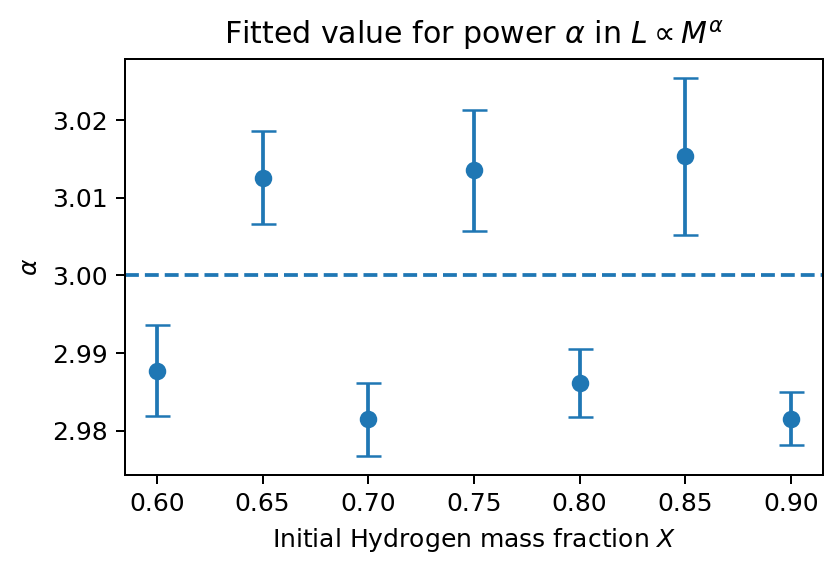

In [ ]:
Xrange = unique(goodGrid.Xs)
cs = []
alphas = []
for index, X in enumerate(Xrange):
    Xgrid = goodGrid.collapse_grid_X(X)
    fit = do_fit_at_X_fixed(Xgrid, True)
    cs.append(fit.params['c'])
    alphas.append(fit.params['alpha'])
fig, ax = plt.subplots(1,1, figsize = (5,3), dpi = 180)
ax.errorbar(Xrange, [alpha.value for alpha in alphas],yerr = [alpha.stderr for alpha in alphas], fmt = 'o', capsize=5)
ax.axhline(3.0, ls='--')
ax.set_xlabel('Initial Hydrogen mass fraction $X$')
ax.set_ylabel('$\\alpha$')
ax.set_title('Fitted value for power $\\alpha$ in $L \propto M^{\\alpha}$')


In [ ]:
fit.params['alpha']

<Parameter 'alpha', value=2.9815628553375735 +/- 0.00342, bounds=[-10:10]>

No using the model $L = f(X(\mu)) M^3$. And $L \propto \frac{1}{\kappa} \mu^4 M^3$, hence $f \propto \mu^4 / \kappa$.

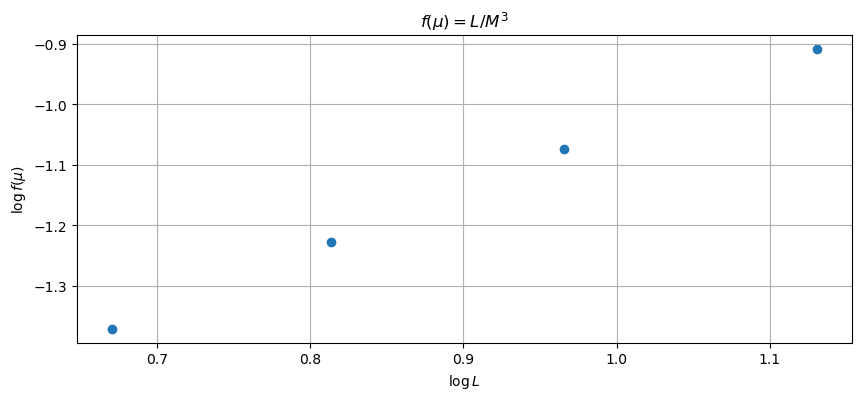

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100)
µs = []
Xs = []
fs = []
logLs = []
for path, logL in dict_logL_ZAMS.items():
    logM, X = get_info_from_path(path)
    if logM != 0:
        continue
    logLs.append(logL)
    µ = get_µ_from_X(X)
    M = 10**logM
    f = µ**4 / (1+X)

    µs.append(µ)
    Xs.append(X)
    fs.append(f)

#ax.scatter(µs, fs, label = 'ZAMS')
ax.scatter(logLs, np.log10(fs))
#ax.scatter(µs, fs, label = 'PMS')
ax.set_xlabel('$\log L$')
ax.set_ylabel('$\log f(\mu)$')
ax.grid()
ax.title.set_text('$f(µ) = L / M^3 $')